In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

In [2]:
import re
import os

In [3]:
from parsedData import parsedData as data

df = pd.DataFrame(data, columns=['Date', 'Time', 'Author', 'Message', 'Conversation'])
df = df.drop('Conversation', axis=1)
df['Word Count'] = df['Message'].apply(lambda s : len(s.split(' ')))
df['Datetime'] = df['Date'] +' '+ df['Time']
# df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True, format='mixed') 
df['Datetime'] = pd.to_datetime(df['Datetime'], yearfirst=True, format='mixed') 
df= df.drop(['Date','Time'], axis=1)
df = df.sort_values(['Datetime'])
df = df[[df.columns[-1], *df.columns[:-1]]]
        # For custom weighting, we'll create a new column with time in days
        # This makes it easier to calculate weights
base_date = df.Datetime.min()
df['days'] = (df.Datetime - base_date).dt.total_seconds() / (24*3600)
df = df.set_index('Datetime')
df

,Author,Message,Word Count,days
Datetime,,,,
2022-05-04 10:47:00,Angelita 🦧,No me has esperado?,5,0.000000
2022-05-04 10:58:00,You,Si :(,3,0.007639
2022-05-04 10:58:00,You,Pensé que querías subir también,6,0.007639
2022-05-04 11:00:00,Angelita 🦧,Te dije espérame,4,0.009028
2022-05-04 11:00:00,Angelita 🦧,:(,2,0.009028
...,...,...,...,...
2025-04-18 06:55:00,Angelita 🦧,Amooor,2,1079.838889
2025-04-18 06:55:00,Angelita 🦧,La gata,3,1079.838889
2025-04-18 06:55:00,Angelita 🦧,Ups,2,1079.838889


In [43]:
linear = MA_ndays_optimized_weighted(df, n=5, filt='linear')
exponential = MA_ndays_optimized_weighted(df, n=5, filt='exponential')
gaussian = MA_ndays_optimized_weighted(df, n=5, filt='gaussian')

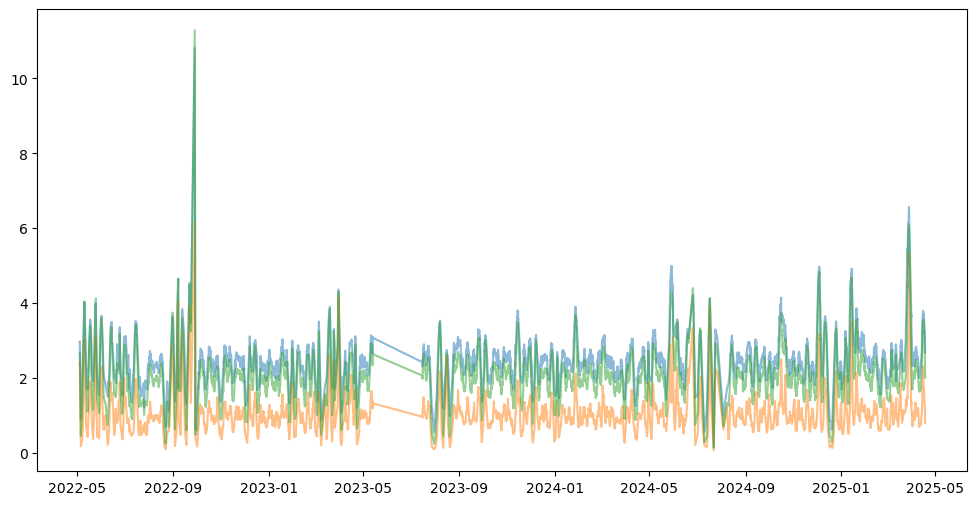

In [47]:
plt.figure(figsize=(12,6))
# plt.ylim(0,100)
# plt.scatter(df.index, df['Word Count'],alpha=0.005,s=2)
# plt.plot(df.index, MA_ndays_optimized(df,n=1),alpha=0.5)
plt.plot(df.index, linear,alpha=0.5)
plt.plot(df.index, exponential,alpha=0.5)
plt.plot(df.index, gaussian,alpha=0.5)
plt.show()

In [40]:
def MA_ndays(temp_df,n=1,filt='uniform'):
    MA = np.zeros(len(temp_df))
    if filt == 'uniform':
        for i in range(len(temp_df)):
            MA[i] = temp_df['Word Count'][(temp_df.Datetime > temp_df.Datetime[i] - DateOffset(days=n)) & (temp_df.Datetime < temp_df.Datetime[i] + DateOffset(days=n))].to_numpy().sum()
        return MA
    return None

In [41]:
def MA_ndays_optimized(temp_df, n=1, filt='uniform'):
    if filt == 'uniform':        
        # Use rolling with a time-based window
        # 2*n days window centered on each point (n days before, n days after)
        window_size = f'{2*n}D'
        
        # Calculate rolling sum with center=True to center the window
        rolling_sum = temp_df_indexed['Word Count'].rolling(
            window=window_size, 
            center=True
        ).mean()
        
        # Reset index to get back original dataframe structure
        rolling_sum = rolling_sum.reset_index()['Word Count']
        
        # Convert to numpy array for consistency with original function
        return rolling_sum.to_numpy()
    
    return None

In [42]:
def MA_ndays_optimized_weighted(temp_df, n=1, filt='linear'):
    temp_df = temp_df.reset_index()
    # Only process if we have data
    if len(temp_df) == 0:
        return np.array([])
    
    # Convert to a regular time series if possible
    # If data is irregularly spaced, this would need adjustment
    
    if filt == 'uniform':
        # Use built-in rolling for uniform weighting
        temp_df_indexed = temp_df.set_index('Datetime')
        window_size = f'{2*n}D'
        rolling_sum = temp_df_indexed['Word Count'].rolling(
            window=window_size, center=True).sum()
        return rolling_sum.reset_index()['Word Count'].to_numpy()
    
    else:
        # For custom weighting, we'll create a new column with time in days
        # This makes it easier to calculate weights
        base_date = temp_df.Datetime.min()
        temp_df['days'] = (temp_df.Datetime - base_date).dt.total_seconds() / (24*3600)
        
        # Define a custom weighted rolling function
        def weighted_roll(x, center_day, decay_type=filt):
            if len(x) == 0:
                return 0
                
            days = x['days'].values
            counts = x['Word Count'].values
            
            # Time differences in days
            time_diffs = abs(days - center_day)
            
            # Apply different decay functions
            if decay_type == 'linear':
                weights = 1 - time_diffs/n
                weights = np.maximum(0, weights)
            elif decay_type == 'exponential':
                weights = np.exp(-time_diffs)
            elif decay_type == 'gaussian':
                sigma = n/3
                weights = np.exp(-(time_diffs**2)/(2*sigma**2))
            else:
                weights = np.ones_like(time_diffs)  # Default to uniform
                
            return np.mean(counts * weights)
        
        # Apply the weighted rolling function
        result = np.zeros(len(temp_df))
        
        # For very large dataframes, consider parallel processing here
        for i in range(len(temp_df)):
            center_day = temp_df['days'].iloc[i]
            window = temp_df[(temp_df['days'] >= center_day - n) & 
                             (temp_df['days'] <= center_day + n)]
            result[i] = weighted_roll(window, center_day, filt)
            
        return result

In [188]:
linear = MA_ndays_optimized_weighted(df, n=5, filt='linear')
exponential = MA_ndays_optimized_weighted(df, n=5, filt='exponential')
gaussian = MA_ndays_optimized_weighted(df, n=5, filt='gaussian')

In [115]:
MA_ndays_optimized(df)

array([2.95736434, 2.95736434, 2.95736434, ..., 3.52879581, 3.52879581,
       3.52879581], shape=(27898,))

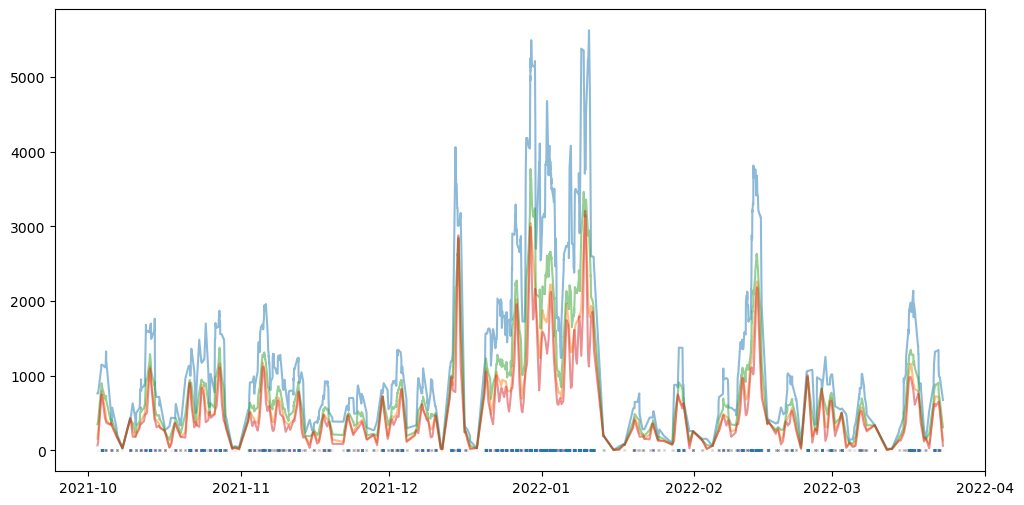

In [171]:
plt.figure(figsize=(12,6))
# plt.ylim(0,10)
plt.scatter(df.index, df['Word Count'],alpha=0.005,s=2)
plt.plot(df.index, MA_ndays_optimized(df,n=1),alpha=0.5)
plt.plot(df.index, linear,alpha=0.5)
plt.plot(df.index, exponential,alpha=0.5)
plt.plot(df.index, gaussian,alpha=0.5)
plt.show()

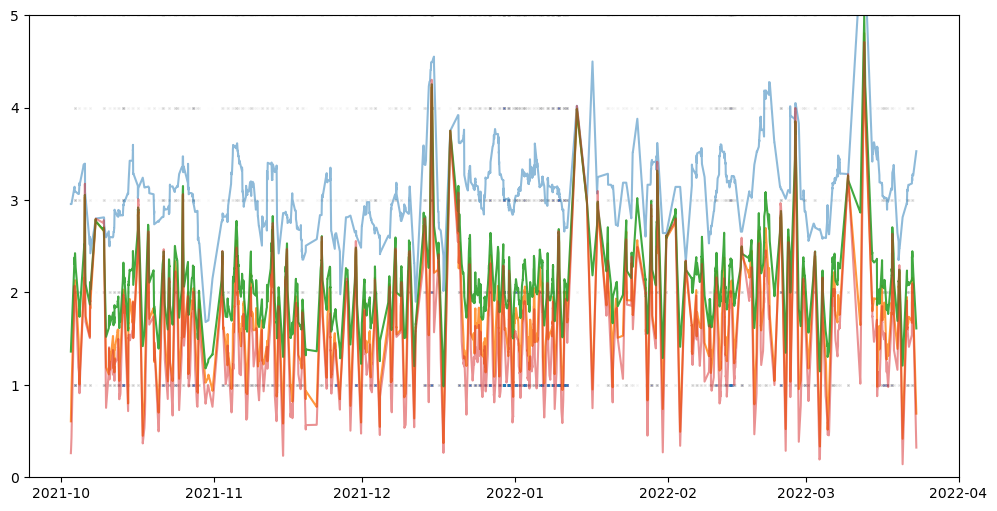

In [187]:
plt.figure(figsize=(12,6))
plt.ylim(0,5)
plt.scatter(df.index, df['Word Count'],alpha=0.005,s=2)
plt.plot(df.index, MA_ndays_optimized(df,n=1),alpha=0.5)
plt.plot(df.index, linear,alpha=0.8)
plt.plot(df.index, exponential,alpha=0.9)
plt.plot(df.index, gaussian,alpha=0.5)
plt.show()

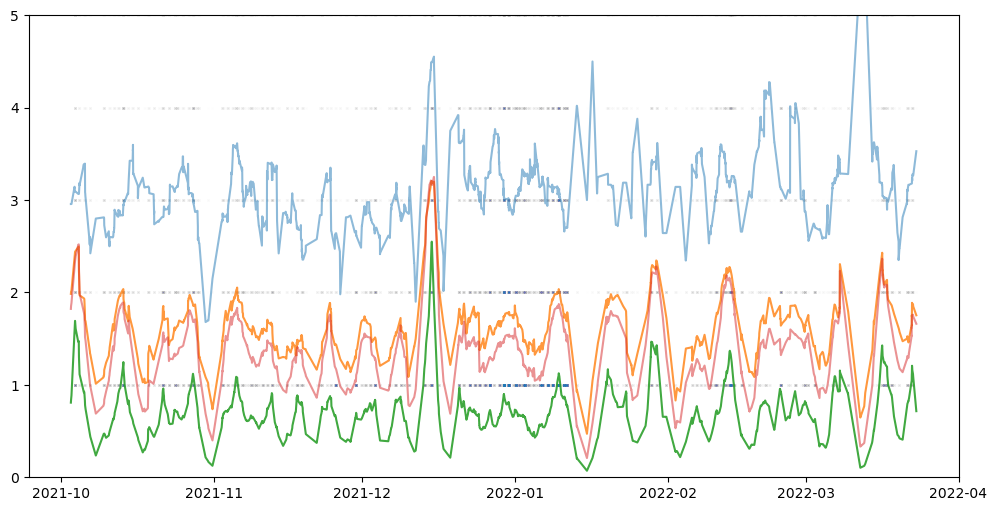

In [189]:
plt.figure(figsize=(12,6))
plt.ylim(0,5)
plt.scatter(df.index, df['Word Count'],alpha=0.005,s=2)
plt.plot(df.index, MA_ndays_optimized(df,n=1),alpha=0.5)
plt.plot(df.index, linear,alpha=0.8)
plt.plot(df.index, exponential,alpha=0.9)
plt.plot(df.index, gaussian,alpha=0.5)
plt.show()